In [17]:
!unzip "small.zip"

Archive:  small.zip
   creating: small/
  inflating: small/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/small/
  inflating: __MACOSX/small/._.DS_Store  
   creating: small/test/
   creating: small/test/dogs/
  inflating: small/test/dogs/dog.2058.jpg  
  inflating: small/test/dogs/dog.2064.jpg  
  inflating: small/test/dogs/dog.2070.jpg  
  inflating: small/test/dogs/dog.2110.jpg  
  inflating: small/test/dogs/dog.2104.jpg  
  inflating: small/test/dogs/dog.2105.jpg  
  inflating: small/test/dogs/dog.2111.jpg  
  inflating: small/test/dogs/dog.2071.jpg  
  inflating: small/test/dogs/dog.2065.jpg  
  inflating: small/test/dogs/dog.2059.jpg  
  inflating: small/test/dogs/dog.2073.jpg  
  inflating: small/test/dogs/dog.2067.jpg  
  inflating: small/test/dogs/dog.2098.jpg  
  inflating: small/test/dogs/dog.2107.jpg  
  inflating: small/test/dogs/dog.2113.jpg  
  inflating: small/test/dogs/dog.2112.jpg  
  inflating: small/test/dogs/dog.2106.jpg  
  inflating: small/test/d

In [0]:
train_dir='small/train/'
validation_dir='small/validation/'
test_dir='small/test/'

In [0]:
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Reshape,AveragePooling2D, SeparableConv2D,Conv2D, MaxPooling2D
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import os

In [0]:
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Reshape,AveragePooling2D, SeparableConv2D,Conv2D, MaxPooling2D
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

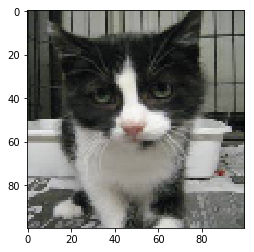

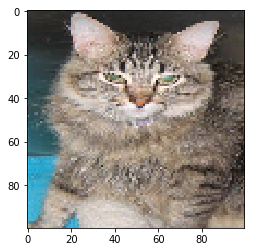

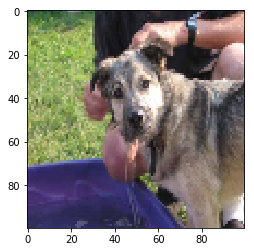

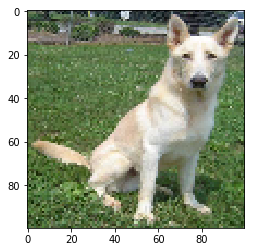

In [28]:
cats_dir=os.path.join(test_dir, 'cats')
fnames = [os.path.join(cats_dir, fname) for fname in os.listdir(cats_dir)][:2]
dogs_dir=os.path.join(test_dir, 'dogs')
fnames.extend([os.path.join(dogs_dir, fname) for fname in os.listdir(dogs_dir)][:2])

# Read the image and resize it
i=0
for img_path in fnames:
  img = image.load_img(img_path, target_size=(100, 100))
  plt.figure(i)
  plt.grid(False)
  imgplot = plt.imshow(img)
  i+=1

plt.show()

In [29]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE=32

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 512 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [0]:
def make_img(data_dir):
  cats_dir=os.path.join(data_dir, 'cats')
  fnames = [os.path.join(cats_dir, fname) for fname in os.listdir(cats_dir)]
  dogs_dir=os.path.join(data_dir, 'dogs')
  fnames.extend([os.path.join(dogs_dir, fname) for fname in os.listdir(dogs_dir)])
  
  return fnames

In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

INPUT_SHAPE=224


def feature_extractor(model, dataset):
  
  features = []
  
  for img_path in dataset:
    img = image.load_img(img_path, target_size=(INPUT_SHAPE, INPUT_SHAPE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    features.append(model.predict(x)[0])
    
  return features
    
  

In [0]:
# MobileNetV2

model = MobileNetV2(weights='imagenet', input_shape=(INPUT_SHAPE,INPUT_SHAPE,3), alpha=1.0, pooling='avg', include_top=False)

train_dir='small/train/'
validation_dir='small/validation/'
test_dir='small/test/'

train_data =  make_img(train_dir)
validation_data = make_img(validation_dir)
test_data = make_img(test_dir)

train_features = feature_extractor(model, train_data)
validation_features = feature_extractor(model, validation_data)
test_features = feature_extractor(model, test_data)



In [0]:
def get_labels(dataset_dir):
  cats_dir=os.path.join(dataset_dir, 'cats')
  fnames = [os.path.join(cats_dir, fname) for fname in os.listdir(cats_dir)]
  cats_labels = np.zeros(len(fnames))
  dogs_dir=os.path.join(dataset_dir, 'dogs')
  dogs = [os.path.join(dogs_dir, fname) for fname in os.listdir(dogs_dir)]
  dogs_labels = np.ones(len(dogs))
  fnames.extend(dogs)
  return fnames, cats_labels, dogs_labels

In [0]:
fnames, train_cats_labels, train_dogs_labels = get_labels(train_dir)
_, test_cats_labels, test_dogs_labels = get_labels(test_dir)
_, validation_cats_labels, validation_dogs_labels = get_labels(validation_dir)

In [0]:
y_train = np.concatenate((train_cats_labels, train_dogs_labels))
y_test = np.concatenate((test_cats_labels, test_dogs_labels))
y_validation = np.concatenate((validation_cats_labels, validation_dogs_labels))

In [48]:
# SVC

from sklearn.svm import SVC
svc = SVC()


svc.fit(train_features, y_train)

err_train = np.mean(y_train != svc.predict(train_features))
err_test  = np.mean(y_test  != svc.predict(test_features))

print(err_train, err_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.001953125 0.01171875


In [58]:
# SVC GRID SEARCH

from sklearn.model_selection import GridSearchCV

Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC()
grid = GridSearchCV(svc, param_grid = {'C': Cs, 'gamma': gamma_array})
grid.fit(validation_features, y_validation)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C

best_gamma = grid.best_estimator_.gamma

print("Best CV Err Best C Best Gamma:")
print(best_cv_err, best_C, best_gamma)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best CV Err Best C Best Gamma:
0.015625 1.0 0.0001


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [59]:
# SVC

from sklearn.svm import SVC
svc = SVC(C=best_C, gamma=best_gamma)


svc.fit(train_features, y_train)

err_train = np.mean(y_train != svc.predict(train_features))
err_test  = np.mean(y_test  != svc.predict(test_features))

print(err_train, err_test)

0.0078125 0.0078125


In [60]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(train_features, y_train)

err_train = np.mean(y_train != knn.predict(train_features))
err_test  = np.mean(y_test  != knn.predict(test_features))

print(err_train, err_test)

0.01171875 0.015625


In [50]:
# Random Forest

from sklearn.metrics import confusion_matrix
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(train_features, y_train)

err_train = np.mean(y_train != rf.predict(train_features))
err_test  = np.mean(y_test  != rf.predict(test_features))


print(err_train, err_test)


0.0 0.0078125
